In [31]:
import numpy as np
import pandas as pd
import os
import warnings
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
warnings.filterwarnings("ignore")


In [32]:
from PIL import Image
from tqdm import tqdm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout,BatchNormalization,MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix

In [33]:
trainpath = "C:\\Users\\manig\\Downloads\\archive (4)\\seg_train\\seg_train"
testpath = "C:\\Users\\manig\\Downloads\\archive (4)\\seg_test\\seg_test"
predpath ="C:\\Users\\manig\\Downloads\\archive (4)\\seg_pred\\seg_pred"

In [34]:
IMAGE_SIZE = (160, 160)

BATCH_SIZE = 32


In [35]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  trainpath,
  seed=123,
  image_size=IMAGE_SIZE,
  batch_size=BATCH_SIZE)

Found 14034 files belonging to 6 classes.


In [36]:
test_ds = tf.keras.utils.image_dataset_from_directory(
  testpath,
  seed=123,
  image_size=IMAGE_SIZE,
  batch_size=BATCH_SIZE)


Found 3000 files belonging to 6 classes.


In [37]:
classes_names=train_ds.class_names
print(classes_names)

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


In [38]:
def getImagePaths(path):
    image_names=[]
    for dirname, _,filenames in os.walk(path):
        for filename in filenames:
            fullpath = os.path.join(dirname, filename)
            image_names.append(fullpath)
    return image_names
images_paths = getImagePaths(predpath)
len(images_paths)

7301

In [39]:
images_paths = getImagePaths(trainpath)
len(images_paths)

14034

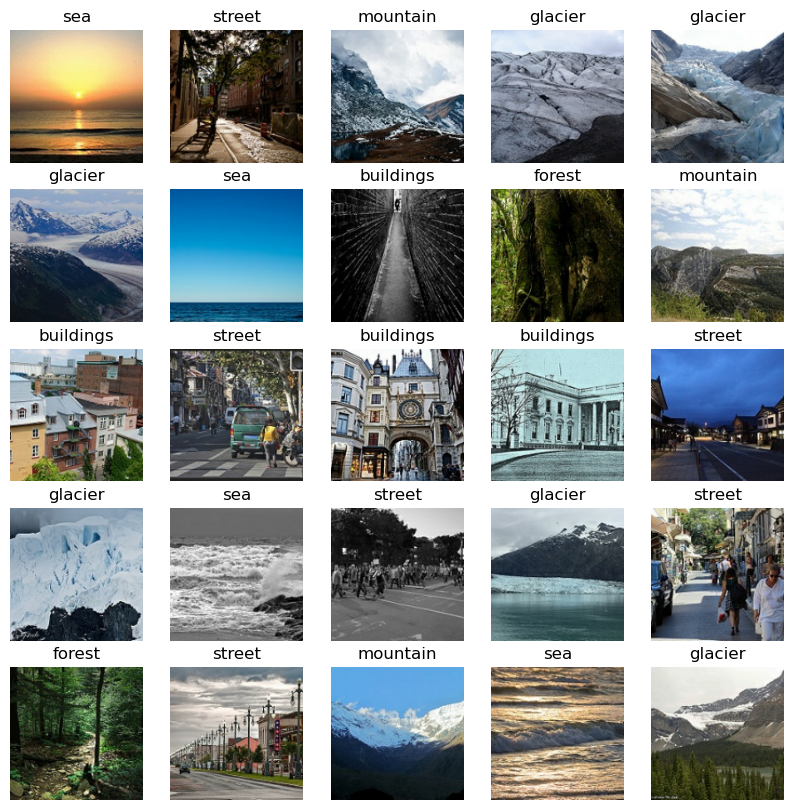

In [40]:
plt.figure(figsize=(10,10))
for images,labels in train_ds.take(1):
    for i in range(25):
        ax=plt.subplot(5,5,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(classes_names[labels[i]])
        plt.axis('off')

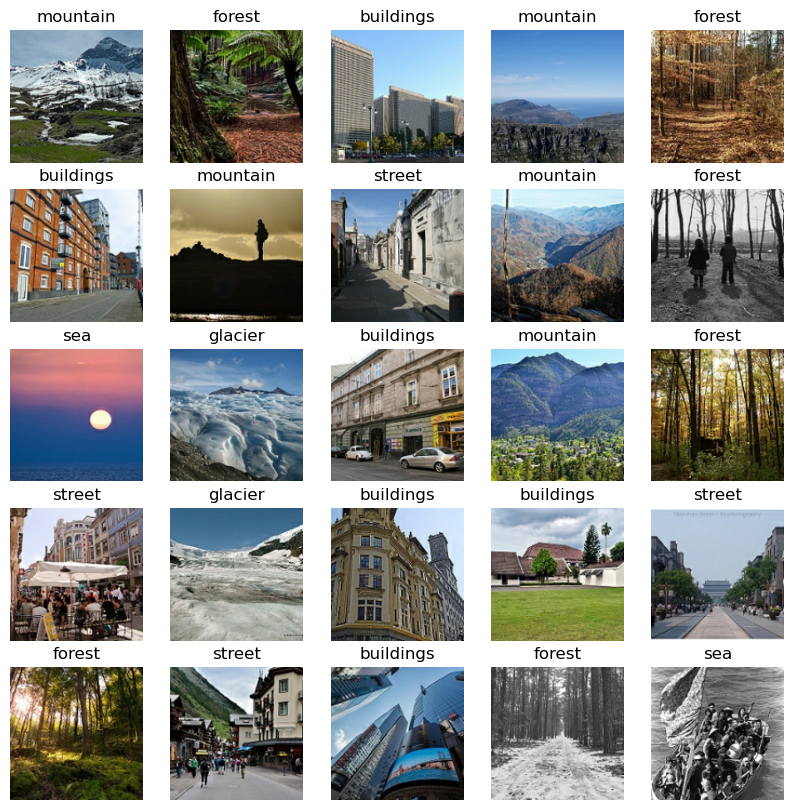

In [41]:
plt.figure(figsize=(10,10))
for image,labels in test_ds.take(1):
    for i in range(25):
        ax=plt.subplot(5,5,i+1)
        plt.imshow(image[i].numpy().astype('uint8'))
        plt.title(classes_names[labels[i]])
        plt.axis('off') 

In [42]:
class_counts = {}
for class_name in os.listdir(trainpath):
    class_dir = os.path.join(trainpath, class_name)  
    if os.path.isdir(class_dir):
        num_images = len(os.listdir(class_dir))  
        class_counts[class_name] = num_images  
for class_name, count in class_counts.items():
    print(f"{class_name}: {count} images")

buildings: 2191 images
forest: 2271 images
glacier: 2404 images
mountain: 2512 images
sea: 2274 images
street: 2382 images


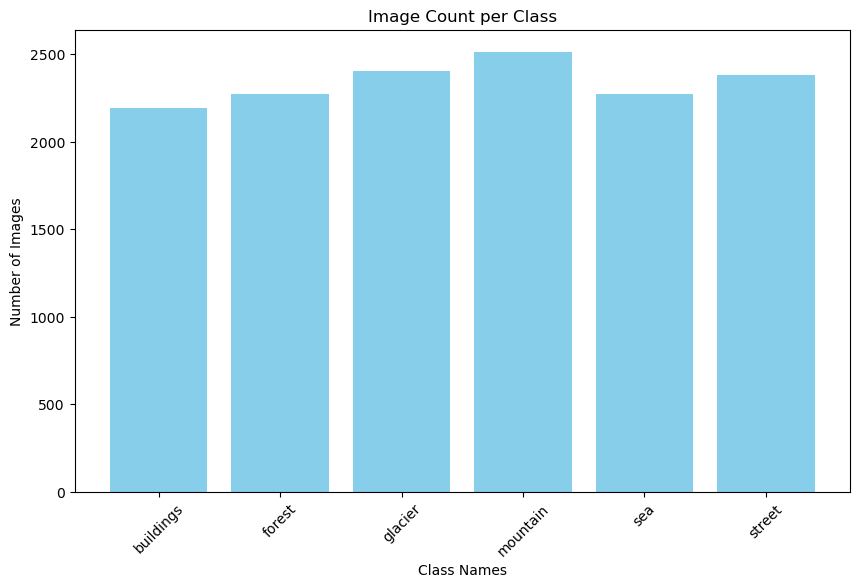

In [43]:
plt.figure(figsize=(10, 6))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.title('Image Count per Class')
plt.xlabel('Class Names')
plt.ylabel('Number of Images')
plt.xticks(rotation=45) 
plt.show()

In [44]:
class_counts = {}
for class_name in os.listdir(testpath):
    class_dir = os.path.join(testpath, class_name)  
    if os.path.isdir(class_dir):
        num_images = len(os.listdir(class_dir))  
        class_counts[class_name] = num_images  
for class_name, count in class_counts.items():
    print(f"{class_name}: {count} images")

buildings: 437 images
forest: 474 images
glacier: 553 images
mountain: 525 images
sea: 510 images
street: 501 images


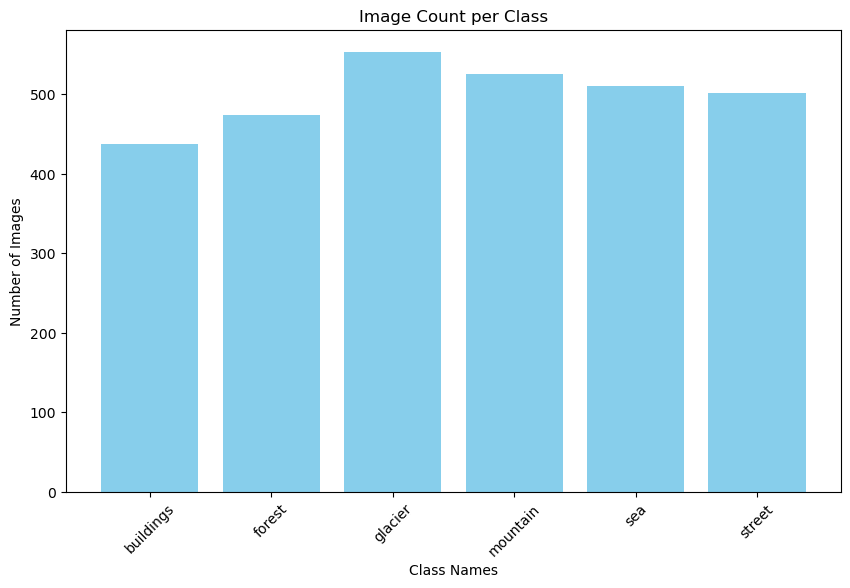

In [45]:
plt.figure(figsize=(10, 6))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.title('Image Count per Class')
plt.xlabel('Class Names')
plt.ylabel('Number of Images')
plt.xticks(rotation=45) 
plt.show()

In [46]:
Norm_layer=tf.keras.layers.Rescaling(1/255)
train_ds=train_ds.map(lambda x , y :(Norm_layer(x),y))
test_ds=test_ds.map(lambda x , y :(Norm_layer(x),y))

In [47]:
model=Sequential()
model.add(Input(shape=(160, 160, 3)))
model.add(Conv2D(32,kernel_size=(5,5),activation='relu'))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(32,kernel_size=(5,5),activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(2,2))

model.add(Flatten())
model.add(Dense(units=1024,activation='relu'))
model.add(Dropout(0.20))
model.add(Dense(124,activation='relu'))
model.add(Dropout(0.20))
model.add(Dense(units=len(classes_names),activation='softmax'))

In [48]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 156, 156, 32)   │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 78, 78, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 74, 74, 32)     │        25,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 37, 37, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 35, 35, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 17, 17, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 15, 15, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 5, 5, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1024)           │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 124)            │       127,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 124)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 6)              │           750 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 483,754 (1.85 MB)

 Trainable params: 483,754 (1.85 MB)

 Non-trainable params: 0 (0.00 B)

In [49]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [50]:
early_stopping=EarlyStopping(monitor='val_accuracy',patience=5,restore_best_weights=True)


In [51]:
history=model.fit(train_ds,validation_data=test_ds,epochs=5,callbacks=[early_stopping])

Epoch 1/5
439/439 ━━━━━━━━━━━━━━━━━━━━ 153s 326ms/step - accuracy: 0.4233 - loss: 1.3698 - val_accuracy: 0.5560 - val_loss: 1.0997
Epoch 2/5
439/439 ━━━━━━━━━━━━━━━━━━━━ 1008s 2s/step - accuracy: 0.6252 - loss: 0.9635 - val_accuracy: 0.6627 - val_loss: 0.8637
Epoch 3/5
439/439 ━━━━━━━━━━━━━━━━━━━━ 128s 292ms/step - accuracy: 0.6847 - loss: 0.8249 - val_accuracy: 0.7253 - val_loss: 0.7320
Epoch 4/5
439/439 ━━━━━━━━━━━━━━━━━━━━ 404s 922ms/step - accuracy: 0.7373 - loss: 0.7084 - val_accuracy: 0.7233 - val_loss: 0.7480
Epoch 5/5
439/439 ━━━━━━━━━━━━━━━━━━━━ 219s 498ms/step - accuracy: 0.7725 - loss: 0.6299 - val_accuracy: 0.7627 - val_loss: 0.6755


In [52]:
loss, accuracy = model.evaluate(test_ds)
print(f'Test accuracy: {accuracy * 100:.2f}%')

94/94 ━━━━━━━━━━━━━━━━━━━━ 9s 94ms/step - accuracy: 0.7568 - loss: 0.6867
Test accuracy: 76.27%


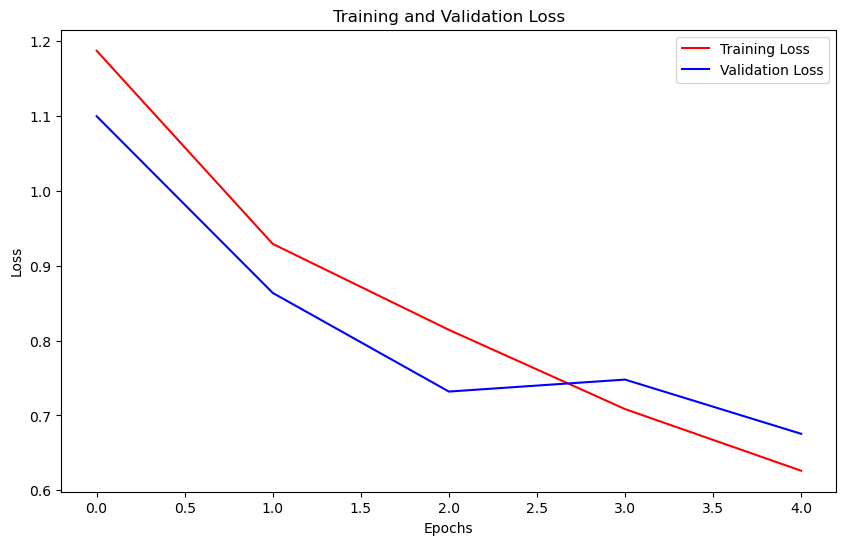

In [53]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, c="red", label="Training Loss")
plt.plot(epochs, val_loss, c="blue", label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

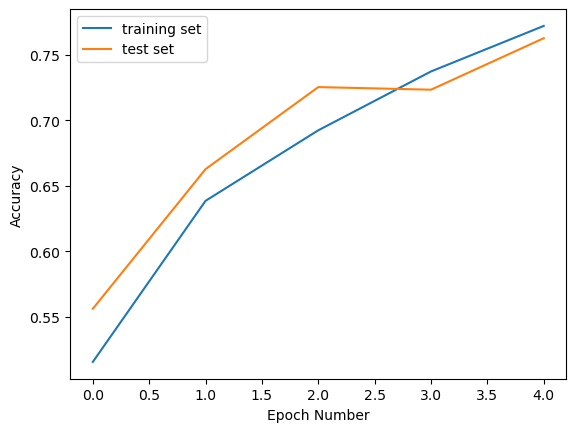

In [54]:
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.plot(history.history['accuracy'], label='training set')
plt.plot(history.history['val_accuracy'], label='test set')
plt.legend()

In [55]:
def predict_img(file_name,model):
    img=image.load_img(file_name,target_size=(228,228))
    img_array=image.img_to_array(img)
    img_pro=np.expand_dims(img_array,axis=0)
    img_pro/=255
    img_pred=model.predict(img_pro)
    index = np.argmax(img_pred)
    
    plt.title("Prediction - {}".format(str(classes_names[index]).title()), size=18, color='red')
    plt.imshow(img_array)

In [56]:
model.save('model.h5')